# Lyft dataset exploration 
## by Grzegorz Lippe

## Preliminary Wrangling

[Lyft Business](https://www.lyftbusiness.com/) (formerly known as Bay Wheels) designs transportation solutions and programs that drive your business forward, reward your people, and upgrade your experience.

Here you'll find Bay Wheels's trip data for public use. So whether you're a designer, developer or just plain curious, feel free to download it and bring it to life. This data is provided according to the Bay Wheels License Agreement.

> Source: [lyft](https://www.lyft.com/bikes/bay-wheels/system-data)
> Dataset for Communicate Data Findings Project

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics.pairwise import haversine_distances
import matplotlib.image as mpimg

%matplotlib inline

The Dataset is provided as one csv file for each month, so I'll investigate 2019, the last whole year.

In [2]:
def _get_csv():
    """Get csv file for analysis.
    
    Of wrangled file is presend load, else read from disk.
    """
    try:
        df = pd.read_csv('baywheels-tripdata-2019.csv', parse_dates=[4, 7])

    except:
        df = pd.DataFrame()
        for m in range(12):
            if m < 4:
                df = df.append(pd.read_csv('2019%02d-fordgobike-tripdata.csv' % (m+1),
                                           parse_dates=[1, 2],
                                           usecols=['start_time',
                                                    'end_time',
                                                    'duration_sec',
                                                    'bike_id',
                                                    'end_station_latitude',
                                                    'end_station_longitude',
                                                    'start_station_latitude', 
                                                    'start_station_longitude',
                                                    'user_type']),
                               sort=True)
            else:
                df = df.append(pd.read_csv('2019%02d-baywheels-tripdata.csv' % (m+1),
                                           parse_dates=[1, 2],
                                           usecols=['start_time',
                                                    'end_time',
                                                    'duration_sec',
                                                    'bike_id',
                                                    'end_station_latitude',
                                                    'end_station_longitude',
                                                    'start_station_latitude', 
                                                    'start_station_longitude',
                                                    'user_type']),
                               sort=True)
        df.to_csv('baywheels-tripdata-2019.csv', index=False)

    return df
   
df = _get_csv()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506983 entries, 0 to 2506982
Data columns (total 9 columns):
bike_id                    int64
duration_sec               int64
end_station_latitude       float64
end_station_longitude      float64
end_time                   datetime64[ns]
start_station_latitude     float64
start_station_longitude    float64
start_time                 datetime64[ns]
user_type                  object
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 172.1+ MB


For plotting reasons I will use the start and end time as indices as well

In [3]:
df.tail()

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,start_station_latitude,start_station_longitude,start_time,user_type
2506978,719651,731,37.807573,-122.421681,2019-12-28 18:49:40,37.809731,-122.409855,2019-12-28 18:37:29,Subscriber
2506979,655411,748,37.807558,-122.421638,2019-12-28 18:49:53,37.809768,-122.409797,2019-12-28 18:37:24,Subscriber
2506980,936881,1044,37.807225,-122.408850,2019-12-26 14:43:02,37.810183,-122.410271,2019-12-26 14:25:37,Subscriber
2506981,397539,326,37.803143,-122.414373,2019-12-30 20:41:09,37.810471,-122.417386,2019-12-30 20:35:43,Subscriber
2506982,662304,4023,37.810970,-122.418054,2019-12-31 20:33:52,37.811042,-122.418149,2019-12-31 19:26:48,Subscriber


### Add travel duration in minuts

It seems easier to work with minutes than seconds.

In [4]:
df['duration_min'] = df.duration_sec/60
df.tail()

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,start_station_latitude,start_station_longitude,start_time,user_type,duration_min
2506978,719651,731,37.807573,-122.421681,2019-12-28 18:49:40,37.809731,-122.409855,2019-12-28 18:37:29,Subscriber,12.183333
2506979,655411,748,37.807558,-122.421638,2019-12-28 18:49:53,37.809768,-122.409797,2019-12-28 18:37:24,Subscriber,12.466667
2506980,936881,1044,37.807225,-122.408850,2019-12-26 14:43:02,37.810183,-122.410271,2019-12-26 14:25:37,Subscriber,17.400000
2506981,397539,326,37.803143,-122.414373,2019-12-30 20:41:09,37.810471,-122.417386,2019-12-30 20:35:43,Subscriber,5.433333
2506982,662304,4023,37.810970,-122.418054,2019-12-31 20:33:52,37.811042,-122.418149,2019-12-31 19:26:48,Subscriber,67.050000


### Add travel distance in kilometers
Also I'll use the Haversine distance to calculate the travelled distance, with the flaw that round trips will result to zero.

$$D(x, y) = 2\arcsin[\sqrt{\sin^2((x1 - y1) / 2)
                         + \cos(x1)\cos(y1)\sin^2((x2 - y2) / 2)}]$$
Source: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)

In [5]:
def single_haversine(x1, y1, x2, y2):
    """Calculate the distance between two points on an sphere.
    
    Uses sklearn's haversine distance function
    """
    return haversine_distances([[x1, y1]], [[x2, y2]])[0][0] * 6371  # km

x1 = np.radians(df.start_station_latitude.values)
y1 = np.radians(df.start_station_longitude.values)
x2 = np.radians(df.end_station_latitude.values)
y2 = np.radians(df.end_station_longitude.values)

df['traveled_dist'] = pd.Series(list(map(single_haversine, x1, y1, x2, y2)))

### Add weekday and month
For some questions it might be interesting to investigate travel by weekday

In [6]:
df['weekday'] = df.start_time.dt.day_name()

And for others the month:

In [7]:
df['month'] = df.start_time.dt.month_name()

In [8]:
df.head()

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,start_station_latitude,start_station_longitude,start_time,user_type,duration_min,traveled_dist,weekday,month
0,4861,80825,37.808894,-122.256460,2019-02-01 16:24:49.864,37.775745,-122.213037,2019-01-31 17:57:44.613,Subscriber,1347.083333,5.305199,Thursday,January
1,5506,65900,37.752428,-122.420628,2019-02-01 15:16:54.173,37.785881,-122.408915,2019-01-31 20:58:33.886,Subscriber,1098.333333,3.859628,Thursday,January
2,2717,62633,37.846784,-122.291376,2019-02-01 11:30:46.530,37.870139,-122.268422,2019-01-31 18:06:52.924,Customer,1043.883333,3.287098,Thursday,January
3,4557,44680,37.775946,-122.437777,2019-02-01 08:10:50.318,37.770083,-122.429156,2019-01-31 19:46:09.719,Customer,744.666667,0.999632,Thursday,January
4,2100,60709,37.787168,-122.388098,2019-02-01 07:10:51.065,37.794130,-122.394430,2019-01-31 14:19:01.541,Customer,1011.816667,0.953355,Thursday,January


In [9]:
# df.to_csv('baywheels-tripdata-2019.csv', index=False)

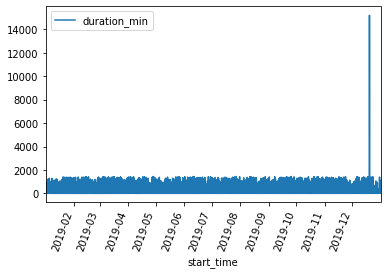

In [10]:
df.plot(x='start_time', y='duration_min');
plt.xticks(rotation=70);

There are som values, where the duration of travel was over 14000 minutes (>230h), whereas most of the travelling was shorter than 2000 minuts. The values above 2000 will be ignored in future.

In [11]:
df.query('duration_min > 1500')

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,start_station_latitude,start_station_longitude,start_time,user_type,duration_min,traveled_dist,weekday,month
2481276,614329,912110,37.327656,-121.868598,2019-12-30 12:37:26,37.323757,-121.878614,2019-12-19 23:15:36,Customer,15201.833333,0.986081,Thursday,December


In [12]:
df = df[df.duration_min < 1500] # drop that one column, which has 14000 minutes ride duraction

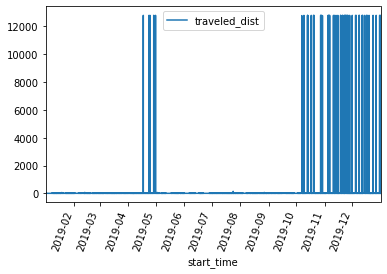

In [13]:
df.plot(x='start_time', y='traveled_dist');
plt.xticks(rotation=70);

There seems to be one customer travelling 60 kilometers on a regular basis. Most travelers yet stay within 10 kilometers.

In [14]:
df.query("traveled_dist > 50")

,bike_id,duration_sec,end_station_latitude,end_station_longitude,end_time,start_station_latitude,start_station_longitude,start_time,user_type,duration_min,traveled_dist,weekday,month
101070,5413,7344,37.337122,-121.883215,2019-01-18 13:39:15.464,37.797320,-122.265320,2019-01-18 11:36:51.405,Subscriber,122.400000,61.259316,Friday,January
304120,4780,6945,37.317298,-121.884995,2019-02-12 16:24:30.158,37.789625,-122.400811,2019-02-12 14:28:44.402,Subscriber,115.750000,69.469241,Tuesday,February
632970,1612,2365,0.000000,0.000000,2019-04-30 19:01:08.146,37.780526,-122.390288,2019-04-30 18:21:42.610,Subscriber,39.416667,12792.805424,Tuesday,April
633736,3507,1964,0.000000,0.000000,2019-04-30 18:04:04.518,37.765052,-122.421866,2019-04-30 17:31:19.646,Subscriber,32.733333,12796.015813,Tuesday,April
633890,1142,546,0.000000,0.000000,2019-04-30 17:54:45.258,37.787327,-122.413278,2019-04-30 17:45:38.452,Subscriber,9.100000,12794.414400,Tuesday,April
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458169,10768,1032,0.000000,0.000000,2019-12-05 12:30:17.370,37.736296,-122.389970,2019-12-05 12:13:05.133,Subscriber,17.200000,12794.560177,Thursday,December
2458833,9959,47600,0.000000,0.000000,2019-12-05 10:03:38.728,37.786375,-122.404904,2019-12-04 20:50:17.859,Customer,793.333333,12793.766945,Wednesday,December
2478506,11419,49921,0.000000,0.000000,2019-12-01 18:28:05.886,37.783899,-122.408445,2019-12-01 04:36:04.283,Customer,832.016667,12794.156716,Sunday,December
2496471,371135,157,0.000000,0.000000,2019-12-31 20:29:07.000,37.766098,-122.396055,2019-12-31 20:26:29.000,Subscriber,2.616667,12793.858998,Tuesday,December


Data shows some traveles, shich ended at long/lat 0,0. That is some faulty data, becaus 0,0 lies on the atlantic ocean.

### What is the structure of your dataset?

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506982 entries, 0 to 2506982
Data columns (total 13 columns):
bike_id                    int64
duration_sec               int64
end_station_latitude       float64
end_station_longitude      float64
end_time                   datetime64[ns]
start_station_latitude     float64
start_station_longitude    float64
start_time                 datetime64[ns]
user_type                  object
duration_min               float64
traveled_dist              float64
weekday                    object
month                      object
dtypes: datetime64[ns](2), float64(6), int64(2), object(3)
memory usage: 267.8+ MB


The structure above is quite self explanatory. The data for station ids is not filled in everywhere, but maybe not every ride starts or ends at a station.


### What is/are the main feature(s) of interest in your dataset?

* How long (duration and distance) are the rides?
* Where are the rides?
* How are the rides distributed around the bikes?
* (How big is the indurance of a bike?)

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

* I already sorted out the needed columns in the ```read_csv``` statement above. 

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

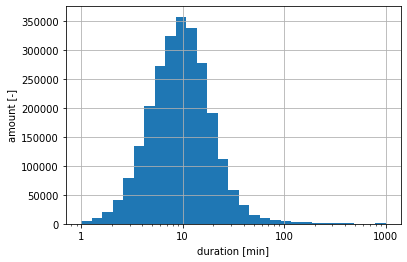

In [32]:
bins = 10**np.linspace(0,3,30)
df.query("duration_min < 2000").duration_min.hist(bins=bins);
plt.xscale('log');
plt.xticks([1, 10, 100, 1000], ['1', '10', '100', '1000']);
plt.xlabel('duration [min]');
plt.ylabel('amount [-]');

The histogram above shows that most of the rides take araound 10 minutes, with some outliers up to 20 hours. 

Text(0, 0.5, 'amount [-]')

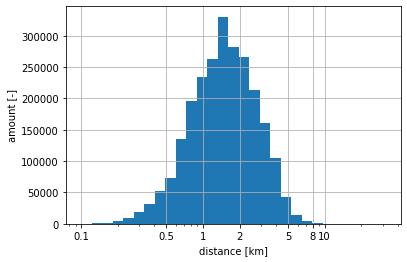

In [31]:
bins = 10**np.linspace(-1,1.5,30)
#dt.resample('1D').plot()
plt.xscale('log');
df.query("start_station_latitude != 0").traveled_dist.hist(bins=bins); # Ignore latitude == 0
plt.xticks([0.1, 0.5, 1, 2, 5,8, 10], ['0.1', '0.5', '1','2', '5', '8', '10']);
plt.xlabel('distance [km]');
plt.ylabel('amount [-]');

### Univariate Exploration Conclusions

* The distributions of the duration of the booked rides iand their time s log normal distributed, so one can conclude, that they originate from a sequence of normal distributed issues.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Take a look at the bike IDs

In [18]:
df.bike_id.nunique()

11070

There are 11 tousand bikes, which travelled 2.5 Million trips. How many trips, and how many kilometers did each bike travel?

In [19]:
df_grouped = df.query('end_station_latitude != 0 and start_station_latitude != 0')
df_grouped = df_grouped.groupby('bike_id')['traveled_dist', 'duration_min'].sum()
df_grouped['average_speed'] = df_grouped.traveled_dist / df_grouped.duration_min * 60 # km / h

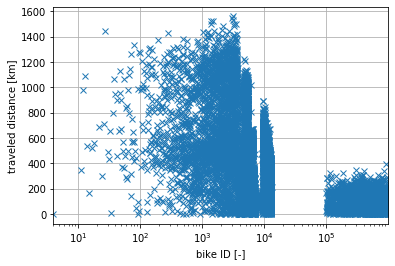

In [20]:
df_grouped.plot(y='traveled_dist',
                linestyle='',
                marker='x',
                legend=False);
plt.xscale('log')
plt.xlabel('bike ID [-]');
plt.ylabel('traveled distance [km]');
plt.grid(True)

- Bikes with IDs smaller than 20.000 travelled up to 1600 kilometers
- There are no bike IDs between 20k and 100k
- Bikes with a higher ID (>90k) travel roundabout 180 kilometers

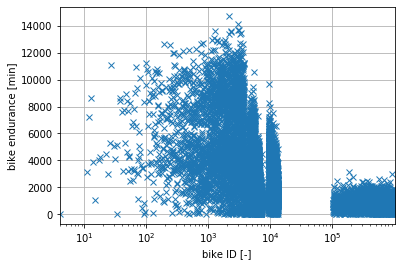

In [21]:
df_grouped.plot(y='duration_min',
                linestyle='',
                marker='x',
                legend=False);
plt.xscale('log')
plt.xlabel('bike ID [-]');
plt.ylabel('bike endurance [min]');
plt.grid(True)

- Bikes with a lower ID not only travelled many more kilometers, they also did this for a higher amount of time.
- Bikes with lower ID endured up to 14.000 minutes (~10d)
- Bikes iwth higher ID only rode 2.000 minutes.

,traveled_dist,duration_min,average_speed
bike_id,,,
162695,18.552016,78.900000,14.107997
372280,14.272999,60.416667,14.174565
117966,289.763702,1217.683333,14.277786
6975,7.434070,31.066667,14.357646
570685,4.630645,18.883333,14.713435
4578,16.552107,63.866667,15.549996
5143,7.869448,22.216667,21.252824


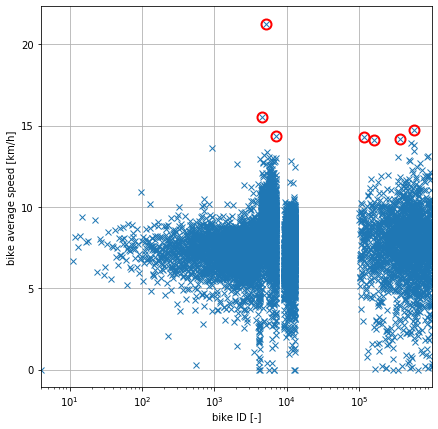

In [22]:
_, ax = plt.subplots(figsize=(7, 7))

df_grouped.plot(y='average_speed',
                linestyle='',
                marker='x',
                legend=False, ax=ax);

df_grouped.query('average_speed > 14').plot(y='average_speed',
                linestyle='', markeredgewidth=2, color='red',
                marker='o', markersize=10, fillstyle='none',
                legend=False, ax=ax);

plt.xscale('log')
plt.xlabel('bike ID [-]');
plt.ylabel('bike average speed [km/h]');
plt.grid(True)

df_grouped.query('average_speed > 14').sort_values('average_speed')

- Spread of speeds seems to go brader with higher ID numbers
- There are some unrealistic high speeds in the graph
- One bike travelled 53 kilometers in 75 minuts, that might be some really sporty guy who challanched himself riding a shared bike 
- The other two trvaelled over 60 kph for a short period of time, so they either travelled down hil or got stolen.

### Map Exploration
Here I used a map for a bivatiate (longitude and lattidue)

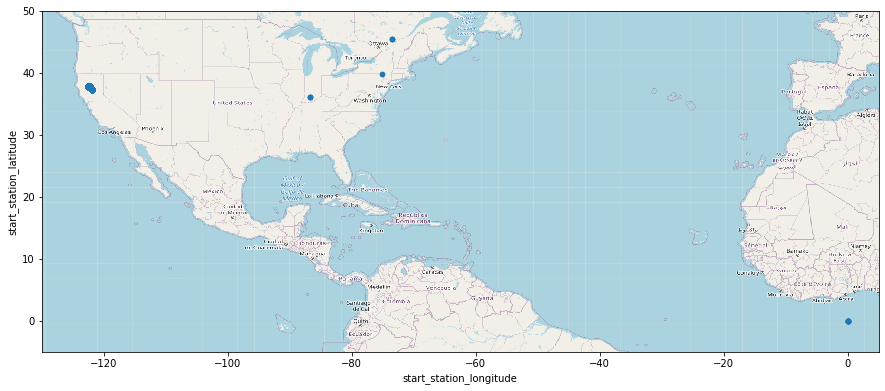

In [23]:
df.plot(x='start_station_longitude', y='start_station_latitude', kind='scatter', figsize=[15,13]);
img = mpimg.imread('map.png')
plt.imshow(img, extent=(-130, 5, -5, 50));

* The map (Source: [OpenStreetMap](http://www.openstreetmap.org)) shows, that there are only 4 clusters for the data.

In [24]:
print(df.query("start_station_longitude < -120").shape[0])
print(df.query("start_station_longitude >= -120").shape[0])

2506959
23


* Data originates within north america
* Most data originates in the San Francisco Bay area.

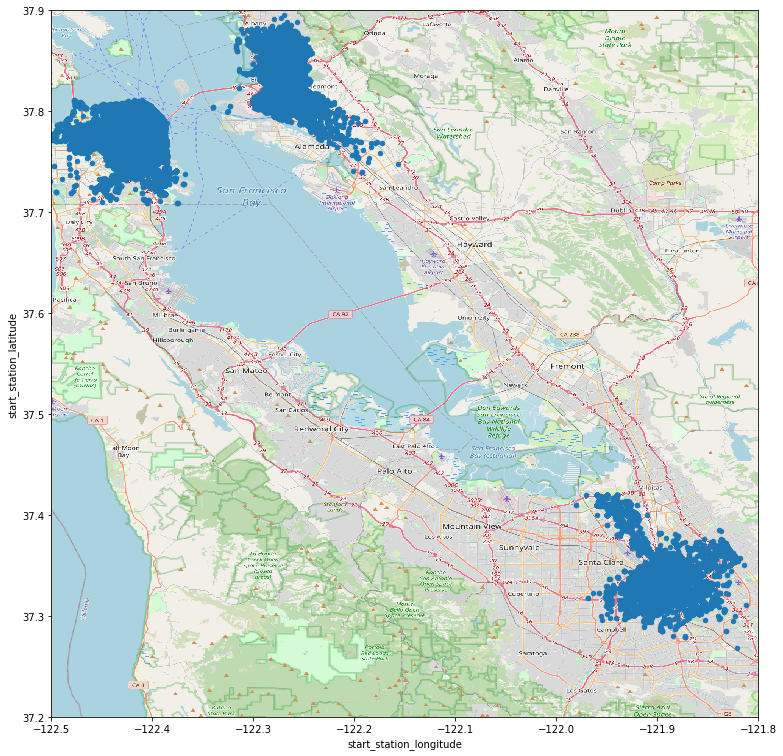

In [25]:
df.query("start_station_longitude < -120").plot(x='start_station_longitude',
                                                y='start_station_latitude', 
                                                kind='scatter', 
                                                figsize=[15,13],
                                                xlim=(-122.5, -121.8),
                                                ylim=(37.2, 37.9));
img = mpimg.imread('bay_area.png')
plt.imshow(img, extent=(-122.5, -121.8, 37.2, 37.9));

### Bivariate Exploration Conclusions

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

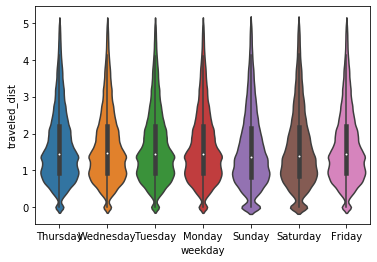

In [26]:
sb.violinplot(x='weekday', y='traveled_dist', data=df.query("start_station_longitude < -120 & traveled_dist < 5"));

* There is a small amount of round trips
* Most of the trips are shorter than 5 km
* No big differences between Weekdays and Weekends

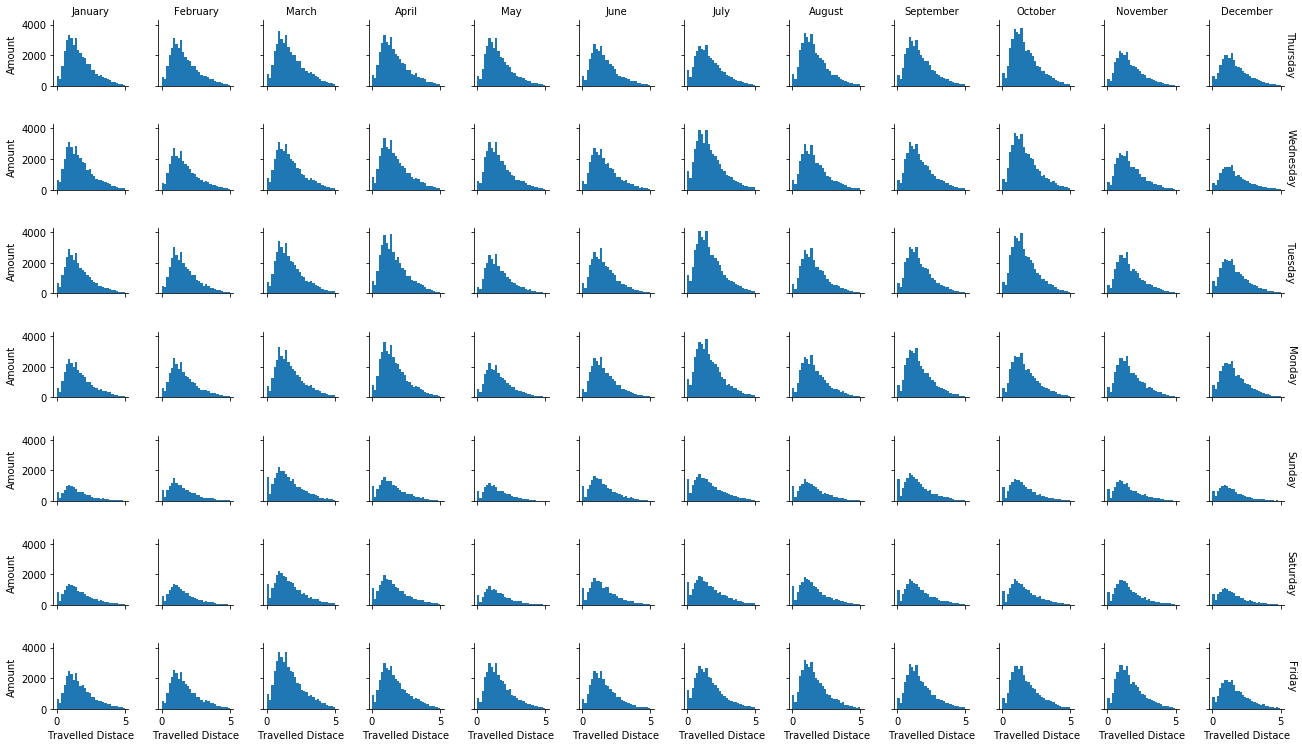

In [27]:
# Initialize a grid of plots with an Axes for each walk
grid = sb.FacetGrid(df.query("start_station_longitude < -120 & traveled_dist < 5"),
                    col="month", row='weekday',
                    margin_titles=True,
                    height=1.5);
grid.map(plt.hist, 'traveled_dist', bins=30);
grid.set_axis_labels("Travelled Distace", "Amount");
[plt.setp(ax.texts, text="") for ax in grid.axes.flat]
grid.set_titles(row_template = '{row_name}', col_template = '{col_name}')

### Multivariate Exploration Conclusions

* Over the year mostly constant travelling
* Saturdays and Fridays are lowest frequencies